In [1]:
import geopandas 
import pandas as pd
pd.set_option('max_colwidth', 200)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from shapely.geometry import Point, Polygon, LineString
import seaborn as sns 
sns.set()
import os
from os import listdir
from os.path import isfile, join
import descartes
import csv
import numpy as np
%matplotlib inline
from random import sample
from math import sin, cos, sqrt, atan2, radians, acos
import numpy as np
import math
import copy
import time

lakes = geopandas.read_file("Lakes_and_Rivers")
madison = geopandas.read_file("City_Limit")


In [2]:
#https://data-cityofmadison.opendata.arcgis.com/datasets/metro-transit-ridership-by-route-weekday?geometry=-89.671%2C42.985%2C-89.23%2C43.161
weekday_bus = geopandas.read_file("Metro_Transit_Ridership_by_Route_Weekday")

#metro data
metro_data = geopandas.read_file("MetroBusRoutes.gdb")
list_metro = []
for index, row in metro_data.iterrows():
    list_metro.append(Point(float(row["stop_lon"]),float(row["stop_lat"])))

metro_series = pd.Series(list_metro)
metro_coord = pd.DataFrame({"Coordinates": metro_series})
metro_coord = geopandas.GeoDataFrame(metro_coord, geometry='Coordinates')

#BRT data 
#https://data-cityofmadison.opendata.arcgis.com/datasets/bus-rapid-transit-stops
# using new data for brt from the madison data instead of the BRT.gdb
brt_data = geopandas.read_file("Bus_Rapid_Transit_Stops")
list_brt = []
for index, row in brt_data.iterrows():
    list_brt.append(Point(float(row["stop_lon"]),float(row["stop_lat"])))

brt_series = pd.Series(list_brt)
brt_coord = pd.DataFrame({"Coordinates": brt_series})
brt_coord = geopandas.GeoDataFrame(brt_coord, geometry='Coordinates')

#BRT data lines
#http://data-cityofmadison.opendata.arcgis.com/datasets/bus-rapid-transit-system-lines
brt_data_line = geopandas.read_file("Bus_Rapid_Transit_System_Lines")
brt_coord_line = geopandas.GeoDataFrame(brt_data_line, geometry='geometry')

#https://data-cityofmadison.opendata.arcgis.com/datasets/metro-transit-ridership-by-route-weekday?geometry=-89.671%2C42.985%2C-89.23%2C43.161
weekday_bus_with_brt_distance = geopandas.read_file("weekday_bus_with_brt_distance_version_2.gpkg")

#metro bus route data 2019
#http://data-cityofmadison.opendata.arcgis.com/datasets/metro-transit-bus-routes
transit_data = geopandas.read_file("Metro_Transit_Bus_Route_Trips")

In [3]:
#https://developers.google.com/transit/gtfs/reference/
#https://wisc-ds-projects.github.io/f19/projects.html
#tried to find a way to save all the links to a variable but didnt work out. 
mypath =r"C:\Users\이진우\cs_summer\Jin_project\mmt_gtfs"
onlyfiles = [f.split('.')[0] for f in listdir(mypath) if isfile(join(mypath, f)) and f.endswith(".txt")]
filedic = {file.split('.')[0]: os.path.join(mypath,file+'.txt') for file in onlyfiles}

filedic



{'agency': 'C:\\Users\\이진우\\cs_summer\\Jin_project\\mmt_gtfs\\agency.txt',
 'calendar': 'C:\\Users\\이진우\\cs_summer\\Jin_project\\mmt_gtfs\\calendar.txt',
 'calendar_dates': 'C:\\Users\\이진우\\cs_summer\\Jin_project\\mmt_gtfs\\calendar_dates.txt',
 'extended_data_dictionary': 'C:\\Users\\이진우\\cs_summer\\Jin_project\\mmt_gtfs\\extended_data_dictionary.txt',
 'fare_attributes': 'C:\\Users\\이진우\\cs_summer\\Jin_project\\mmt_gtfs\\fare_attributes.txt',
 'fare_rules': 'C:\\Users\\이진우\\cs_summer\\Jin_project\\mmt_gtfs\\fare_rules.txt',
 'feed_info': 'C:\\Users\\이진우\\cs_summer\\Jin_project\\mmt_gtfs\\feed_info.txt',
 'linked_datasets': 'C:\\Users\\이진우\\cs_summer\\Jin_project\\mmt_gtfs\\linked_datasets.txt',
 'routes': 'C:\\Users\\이진우\\cs_summer\\Jin_project\\mmt_gtfs\\routes.txt',
 'shapes': 'C:\\Users\\이진우\\cs_summer\\Jin_project\\mmt_gtfs\\shapes.txt',
 'stops': 'C:\\Users\\이진우\\cs_summer\\Jin_project\\mmt_gtfs\\stops.txt',
 'stop_features': 'C:\\Users\\이진우\\cs_summer\\Jin_project\\mmt_gtfs\\st

In [4]:
stop_table =  pd.read_csv(r"C:\\Users\\이진우\\cs_summer\\Jin_project\\mmt_gtfs\\stops.txt", sep=",", engine='python')
stop_table.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,agency_id,jurisdiction_id,location_type,parent_station,relative_position,cardinal_direction,wheelchair_boarding,primary_street,address_range,cross_location
0,1110,1110,E Dayton & Wisconsin (WB),This EVENT/DETOUR ONLY stop (#1110) is westbound on the 2 block of Dayton St (E) nearside of Wisconsin Ave,43.076428,-89.385920,MMT,CMAD,0,NaN,3,270.0,1,E Dayton,2,Wisconsin
1,1111,1111,W Doty & M L K Junior (EB),This EVENT/DETOUR ONLY stop (#1111) is eastbound on the 1 block of Doty St (W) nearside of Martin Luther King Jr Blvd,43.072938,-89.382354,MMT,CMAD,0,NaN,3,90.0,1,W Doty,1,M L K Junior
2,1124,1124,S Fairchild & W Main (SB),This EVENT/DETOUR ONLY stop (#1124) is southbound on the 98 block of Fairchild St (S) nearside of Main St (W),43.072467,-89.385273,MMT,CMAD,0,NaN,3,180.0,1,S Fairchild,98,W Main
3,1135,1135,N Webster & E Mifflin (NB),This EVENT/DETOUR ONLY stop (#1135) is northbound on the 101 block of Webster St (N) farside of Mifflin St (E),43.077272,-89.383413,MMT,CMAD,0,NaN,1,0.0,1,N Webster,101,E Mifflin
4,1140,1140,E Washington & N Webster (WB),This EVENT/DETOUR ONLY stop (#1140) is westbound on the 200 block of E Washington Ave nearside of Webster St (N),43.076390,-89.381930,MMT,CMAD,0,NaN,3,270.0,1,E Washington,200,N Webster


In [5]:
with open('DFS_output_7-9AM.csv') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
        row=row
        break


In [6]:
begin_stop = []
begin_stop_fixed = []
list_of_stops = []
list_of_stops_fixed = []
stops=row[1].strip(",[,],{,}")
stops=stops.split(',')
begin_stop.append(row[0])
for stop in begin_stop:
    stop_fixed=stop.split('_')[0]
    stop_fixed =''.join(i for i in stop_fixed if i.isdigit())
    begin_stop_fixed.append(stop_fixed)
    
for stop in stops:
    list_of_stops.append(stop)
for stop in list_of_stops:
    stop_fixed=stop.split('_')[0]
    stop_fixed =''.join(i for i in stop_fixed if i.isdigit())
    list_of_stops_fixed.append(stop_fixed)

In [7]:
list_stops = []
row = ''
for stops in begin_stop_fixed:
    row = stop_table[stop_table['stop_id'] == int(stops)]
    try:
        lat=row['stop_lat'].values[0]
        lon = row['stop_lon'].values[0]
    except:
        print(stops)
        print(row)
        break
    list_stops.append(Point(float(lon),float(lat)))

first_stops_series = pd.Series(list_stops)
first_stops_coord = pd.DataFrame({"Coordinates": first_stops_series})
first_stops_coord = geopandas.GeoDataFrame(first_stops_coord, geometry='Coordinates')

list_stops = []
row = ''
for stops in list_of_stops_fixed:
    row = stop_table[stop_table['stop_id'] == int(stops)]
    try:
        lat=row['stop_lat'].values[0]
        lon = row['stop_lon'].values[0]
    except:
        print(stops)
        print(row)
        break
    list_stops.append(Point(float(lon),float(lat)))

stops_series = pd.Series(list_stops)
stops_coord = pd.DataFrame({"Coordinates": stops_series})
stops_coord = geopandas.GeoDataFrame(stops_coord, geometry='Coordinates')

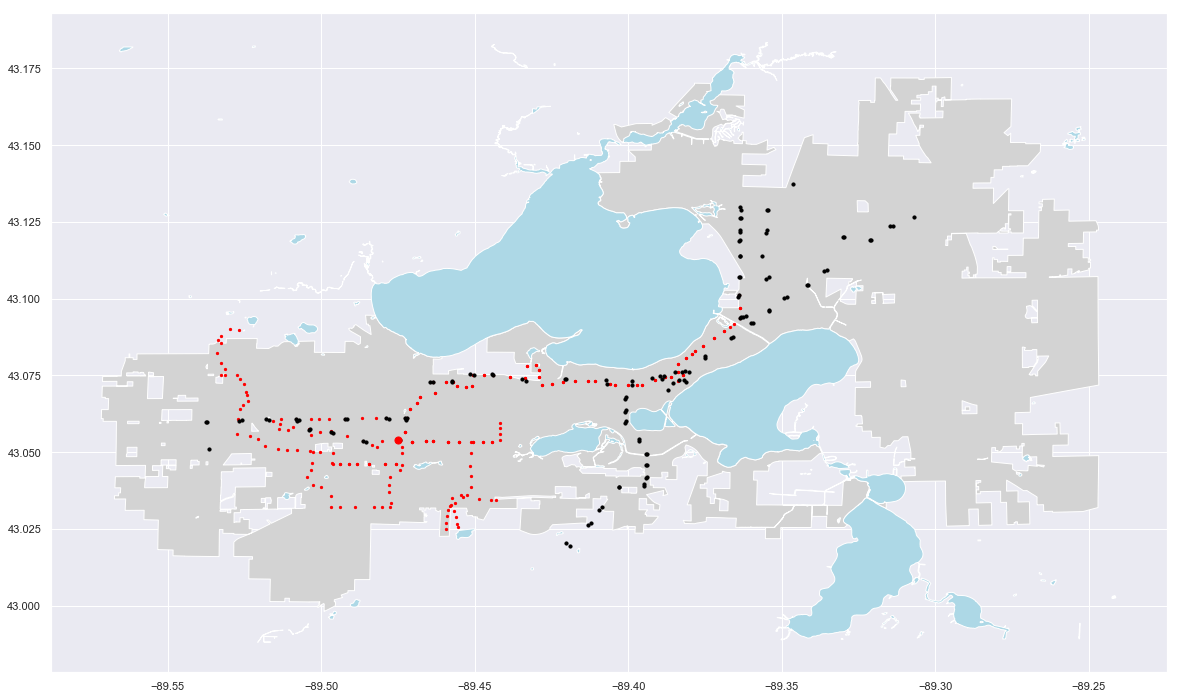

In [8]:
ax = madison.plot(color="lightgray", figsize=(20,20))
lakes.plot(color="lightblue", ax=ax)

stops_coord.plot(color="red", ax=ax, markersize= 5)
brt_coord.plot(color="black", ax=ax, markersize= 10)
first_stops_coord.plot(color="red", ax=ax, markersize= 50)